In [12]:
import polars as pl

try:
    lazy_df = pl.scan_csv("flights.csv", null_values=[""])
except FileNotFoundError:
    print("flights.csv not found. Please provide the correct path.")
    exit()

hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

for col in hhmm_columns:
  lazy_df = lazy_df.with_columns([
      (
          (pl.col(col) // 100 * 3600 + pl.col(col) % 100 * 60).cast(pl.Int64).cast(pl.Time)
      ).alias(col + "_time")
  ])


minute_columns = [
    "DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME",
    "AIR_TIME", "TAXI_IN", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

# Convert integer minutes to Duration (in minutes)
lazy_df = lazy_df.with_columns([
    (pl.col(col).fill_null(0).cast(pl.Int64) * pl.duration(minutes=1)).alias(col + "_duration")
    for col in minute_columns
])


columns_to_keep = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "FLIGHT_NUMBER",
    "TAIL_NUMBER", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DISTANCE",
    "DIVERTED", "CANCELLED", "CANCELLATION_REASON"
]

time_cols = [col + "_time" for col in hhmm_columns]
duration_cols = [col + "_duration" for col in minute_columns]

result_df = lazy_df.select(columns_to_keep + time_cols + duration_cols).collect()

print(result_df)
print(result_df.dtypes)

shape: (5_819_079, 31)
┌──────┬───────┬─────┬─────────────┬───┬───────────────────┬───────────────────┬───────────────────┬───────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY_du ┆ AIRLINE_DELAY_dur ┆ LATE_AIRCRAFT_DEL ┆ WEATHER_DELAY_dur │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ration            ┆ ation             ┆ AY_duration       ┆ ation             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ ---               ┆ ---               ┆ ---               ┆ ---               │
│      ┆       ┆     ┆             ┆   ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      │
╞══════╪═══════╪═════╪═════════════╪═══╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 0µs               ┆ 0µs               ┆ 0µs               ┆ 0µs               │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 0µs               ┆ 0µs               ┆ 0µs               ┆ 0µs               │
│ 2015 ┆ 

In [14]:
result_df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DIVERTED,CANCELLED,CANCELLATION_REASON,SCHEDULED_DEPARTURE_time,DEPARTURE_TIME_time,WHEELS_OFF_time,WHEELS_ON_time,SCHEDULED_ARRIVAL_time,ARRIVAL_TIME_time,DEPARTURE_DELAY_duration,TAXI_OUT_duration,SCHEDULED_TIME_duration,ELAPSED_TIME_duration,AIR_TIME_duration,TAXI_IN_duration,ARRIVAL_DELAY_duration,AIR_SYSTEM_DELAY_duration,SECURITY_DELAY_duration,AIRLINE_DELAY_duration,LATE_AIRCRAFT_DELAY_duration,WEATHER_DELAY_duration
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,str,time,time,time,time,time,time,duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs]
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",1448,0,0,null,00:00:00.000000300,00:00:00.000086040,00:00:00.000000900,00:00:00.000014640,00:00:00.000016200,00:00:00.000014880,-11m,21m,3h 25m,3h 14m,2h 49m,4m,-22m,0µs,0µs,0µs,0µs,0µs
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",2330,0,0,null,00:00:00.000000600,00:00:00.000000120,00:00:00.000000840,00:00:00.000027420,00:00:00.000028200,00:00:00.000027660,-8m,12m,4h 40m,4h 39m,4h 23m,4m,-9m,0µs,0µs,0µs,0µs,0µs
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",2296,0,0,null,00:00:00.000001200,00:00:00.000001080,00:00:00.000002040,00:00:00.000028800,00:00:00.000029160,00:00:00.000029460,-2m,16m,4h 46m,4h 53m,4h 26m,11m,5m,0µs,0µs,0µs,0µs,0µs
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",2342,0,0,null,00:00:00.000001200,00:00:00.000000900,00:00:00.000001800,00:00:00.000028080,00:00:00.000029100,00:00:00.000028560,-5m,15m,4h 45m,4h 41m,4h 18m,8m,-9m,0µs,0µs,0µs,0µs,0µs
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",1448,0,0,null,00:00:00.000001500,00:00:00.000001440,00:00:00.000002100,00:00:00.000010440,00:00:00.000012,00:00:00.000010740,-1m,11m,3h 55m,3h 35m,3h 19m,5m,-21m,0µs,0µs,0µs,0µs,0µs


In [17]:
import polars as pl
import pandas as pd
import numpy as np

try:
    lazy_df = pl.scan_csv("flights.csv", null_values=[""])
except FileNotFoundError:
    print("flights.csv not found. Please provide the correct path.")
    exit()

hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

for col in hhmm_columns:
    lazy_df = lazy_df.with_columns(
        ((pl.col(col) // 100) + (pl.col(col) % 100) / 60).alias(col + "_decimal") # Convert to decimal
    ).with_columns(
        (
            (pl.col(col) // 100 * 3600 + pl.col(col) % 100 * 60).cast(pl.Int64).cast(pl.Time)
        ).alias(col + "_time") #Convert to time
    )


minute_columns = [
    "DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME",
    "AIR_TIME", "TAXI_IN", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

# Collect to DataFrame *before* creating Pandas Series
# Collect to DataFrame *before* creating Pandas Series
df = lazy_df.collect()

df = lazy_df.collect()

for col in minute_columns:
    # 1. Fill NaN values with 0 in the Polars DataFrame *first*
    df = df.with_columns(pl.col(col).fill_null(0))

    # 2. Create the Pandas Series
    pandas_series = pd.Series(df[col].to_numpy(), name=col + "_minutes")

    # 3. Add the Pandas Series back to the Polars DataFrame
    df = df.with_columns(pl.Series(pandas_series).alias(col + "_minutes"))

    # 4. Convert to duration (using the original column, not the Pandas Series)
    df = df.with_columns((pl.col(col) * pl.duration(minutes=1)).alias(col + "_duration"))

columns_to_keep = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "FLIGHT_NUMBER",
    "TAIL_NUMBER", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DISTANCE",
    "DIVERTED", "CANCELLED", "CANCELLATION_REASON"
]

time_decimal_cols = [col + "_decimal" for col in hhmm_columns]
time_cols = [col + "_time" for col in hhmm_columns]
minute_cols = [col + "_minutes" for col in minute_columns]
duration_cols = [col + "_duration" for col in minute_columns]

result_df = df.select(columns_to_keep + time_decimal_cols + time_cols + minute_cols + duration_cols)

print(result_df)
print(result_df.dtypes)

shape: (5_819_079, 49)
┌──────┬───────┬─────┬─────────────┬───┬───────────────────┬───────────────────┬───────────────────┬───────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY_du ┆ AIRLINE_DELAY_dur ┆ LATE_AIRCRAFT_DEL ┆ WEATHER_DELAY_dur │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ration            ┆ ation             ┆ AY_duration       ┆ ation             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ ---               ┆ ---               ┆ ---               ┆ ---               │
│      ┆       ┆     ┆             ┆   ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      │
╞══════╪═══════╪═════╪═════════════╪═══╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 0µs               ┆ 0µs               ┆ 0µs               ┆ 0µs               │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 0µs               ┆ 0µs               ┆ 0µs               ┆ 0µs               │
│ 2015 ┆ 

In [19]:
result_df.describe()

statistic,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DIVERTED,CANCELLED,CANCELLATION_REASON,SCHEDULED_DEPARTURE_decimal,DEPARTURE_TIME_decimal,WHEELS_OFF_decimal,WHEELS_ON_decimal,SCHEDULED_ARRIVAL_decimal,ARRIVAL_TIME_decimal,SCHEDULED_DEPARTURE_time,DEPARTURE_TIME_time,WHEELS_OFF_time,WHEELS_ON_time,SCHEDULED_ARRIVAL_time,ARRIVAL_TIME_time,DEPARTURE_DELAY_minutes,TAXI_OUT_minutes,SCHEDULED_TIME_minutes,ELAPSED_TIME_minutes,AIR_TIME_minutes,TAXI_IN_minutes,ARRIVAL_DELAY_minutes,AIR_SYSTEM_DELAY_minutes,SECURITY_DELAY_minutes,AIRLINE_DELAY_minutes,LATE_AIRCRAFT_DELAY_minutes,WEATHER_DELAY_minutes,DEPARTURE_DELAY_duration,TAXI_OUT_duration,SCHEDULED_TIME_duration,ELAPSED_TIME_duration,AIR_TIME_duration,TAXI_IN_duration,ARRIVAL_DELAY_duration,AIR_SYSTEM_DELAY_duration,SECURITY_DELAY_duration,AIRLINE_DELAY_duration,LATE_AIRCRAFT_DELAY_duration,WEATHER_DELAY_duration
str,f64,f64,f64,f64,str,f64,str,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str
"""count""",5.819079e6,5.819079e6,5.819079e6,5.819079e6,"""5819079""",5.819079e6,"""5804358""","""5819079""","""5819079""",5.819079e6,5.819079e6,5.819079e6,"""89884""",5.819079e6,5.732926e6,5.730032e6,5.726566e6,5.819079e6,5.726566e6,"""5819079""","""5732926""","""5730032""","""5726566""","""5819079""","""5726566""",5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,5.819079e6,"""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079""","""5819079"""
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,"""14721""","""0""","""0""",0.0,0.0,0.0,"""5729195""",0.0,86153.0,89047.0,92513.0,0.0,92513.0,"""0""","""86153""","""89047""","""92513""","""0""","""92513""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",2015.0,6.524085,15.704594,3.926941,null,2173.092742,null,null,null,822.356495,0.00261,0.015446,null,13.473922,13.553252,13.7632,14.912745,15.130367,14.961991,"""00:00:00.000048""","""00:00:00.000048""","""00:00:00.000049""","""00:00:00.000053""","""00:00:00.000054""","""00:00:00.000053""",9.231431,15.825724,141.685745,134.532365,111.462029,7.316768,4.327482,2.463579,0.013917,3.466692,4.28967,0.53277,"""0:09:13.885836""","""0:15:49.543448""","""2:21:41.144727""","""2:14:31.941910""","""1:51:27.721727""","""0:07:19.006079""","""0:04:19.648934""","""0:02:27.814752""","""0:00:00.835029""","""0:03:28.001534""","""0:04:17.380224""","""0:00:31.966223"""
"""std""",0.0,3.405137,8.783425,1.988845,null,1757.063999,null,null,null,607.784287,0.05102,0.12332,null,4.849804,4.960771,4.983522,5.224143,5.075373,5.265878,null,null,null,null,null,null,36.822816,9.045025,75.210681,75.767087,73.154215,5.670329,38.919559,13.055845,0.916786,21.854996,20.574213,8.807465,null,null,null,null,null,null,null,null,null,null,null,null
"""min""",2015.0,1.0,1.0,1.0,"""AA""",1.0,"""7819A""","""10135""","""10135""",21.0,0.0,0.0,"""A""",0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,"""00:00:00""","""00:00:00""","""00:00:00""","""00:00:00""","""00:00:00""","""00:00:00""",-82.0,0.0,0.0,0.0,0.0,0.0,-87.0,0.0,0.0,0.0,0.0,0.0,"""-1 day, 22:38:00""","""0:00:00""","""0:00:00""","""0:00:00""","""0:00:00""","""0:00:00""","""-1 day, 22:33:00""","""0:00:00""","""0:00:00""","""0:00:00""","""0:00:00""","""0:00:00"""
"""25%""",2015.0,4.0,8.0,2.0,null,730.0,null,null,null,373.0,0.0,0.0,null,9.283333,9.35,9.583333,10.9,11.166667,10.983333,"""00:00:00.000033""","""00:00:00.000033""","""00:00:00.000034""","""00:00:00.000039""","""00:00:00.000040""","""00:00:00.000039""",-5.0,11.0,85.0,81.0,59.0,4.0,-13.0,0.0,0.0,0.0,0.0,0.0,"""-1 day, 23:55:00""","""0:11:00""","""1:25:00""","""1:21:00""","""0:59:00"

In [20]:
import polars as pl
from io import StringIO

# Sample CSV data
data = """YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,2354,-11,21,0015,205,194,169,1448,0404,4,0430,0408,-22,0,0,,,,,,
2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,0002,-8,12,0014,280,279,263,2330,0737,4,0750,0741,-9,0,0,,,,,,
2015,1,1,4,US,840,N171US,SFO,CLT,0020,0018,-2,16,0034,286,293,266,2296,0800,11,0806,0811,5,0,0,,,,,,
2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,0015,-5,15,0030,285,281,258,2342,0748,8,0805,0756,-9,0,0,,,,,,
2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,0024,-1,11,0035,235,215,199,1448,0254,5,0320,0259,-21,0,0,,,,,,
2015,1,1,4,DL,806,N3730B,SFO,MSP,0025,0020,-5,18,0038,217,230,206,1589,0604,6,0602,0610,8,0,0,,,,,,
2015,1,1,4,NK,612,N635NK,LAS,MSP,0025,0019,-6,11,0030,181,170,154,1299,0504,5,0526,0509,-17,0,0,,,,,,
2015,1,1,4,US,2013,N584UW,LAX,CLT,0030,0044,14,13,0057,273,249,228,2125,0745,8,0803,0753,-10,0,0,,,,,,
2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,0030,0019,-11,17,0036,195,193,173,1464,0529,3,0545,0532,-13,0,0,,,,,,
2015,1,1,4,DL,1173,N826DN,LAS,ATL,0030,0033,3,12,0045,221,203,186,1747,0651,5,0711,0656,-15,0,0,,,,,,
2015,1,1,4,DL,2336,N958DN,DEN,ATL,0030,0024,-6,12,0036,173,149,133,1199,0449,4,0523,0453,-30,0,0,,,,,,
2015,1,1,4,AA,1674,N853AA,LAS,MIA,0035,0027,-8,21,0048,268,266,238,2174,0746,7,0803,0753,-10,0,0,,,,,,
2015,1,1,4,DL,1434,N547US,LAX,MSP,0035,0035,0,18,0053,214,210,188,1535,0601,4,0609,0605,-4,0,0,,,,,,
2015,1,1,4,DL,2324,N3751B,SLC,ATL,0040,0034,-6,18,0052,215,199,176,1590,0548,5,0615,0553,-22,0,0,,,,,,
2015,1,1,4,DL,2440,N651DL,SEA,MSP,0040,0039,-1,28,0107,189,198,166,1399,0553,4,0549,0557,8,0,0,,,,,,
2015,1,1,4,AS,108,N309AS,ANC,SEA,0045,0041,-4,17,0058,204,194,173,1448,0451,4,0509,0455,-14,0,0,,,,,,
2015,1,1,4,DL,1560,N3743H,ANC,SEA,0045,0031,-14,25,0056,210,200,171,1448,0447,4,0515,0451,-24,0,0,,,,,,
2015,1,1,4,UA,1197,N78448,SFO,IAH,0048,0042,-6,11,0053,218,217,199,1635,0612,7,0626,0619,-7,0,0,,,,,,"""

# Load the data into a Polars DataFrame
df = pl.read_csv(StringIO(data))

# Convert relevant columns to duration
df = df.with_columns([
    pl.duration(minutes=pl.col("DEPARTURE_DELAY")).alias("DEPARTURE_DELAY_DURATION"),
    pl.duration(minutes=pl.col("TAXI_OUT")).alias("TAXI_OUT_DURATION"),
    pl.duration(minutes=pl.col("SCHEDULED_TIME")).alias("SCHEDULED_TIME_DURATION"),
    pl.duration(minutes=pl.col("ELAPSED_TIME")).alias("ELAPSED_TIME_DURATION"),
    pl.duration(minutes=pl.col("AIR_TIME")).alias("AIR_TIME_DURATION"),
    pl.duration(minutes=pl.col("TAXI_IN")).alias("TAXI_IN_DURATION"),
    pl.duration(minutes=pl.col("ARRIVAL_DELAY")).alias("ARRIVAL_DELAY_DURATION"),
])

# Show the resulting DataFrame
print(df)


shape: (18, 38)
┌──────┬───────┬─────┬─────────────┬───┬────────────────────┬───────────────────┬──────────────────┬───────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ ELAPSED_TIME_DURAT ┆ AIR_TIME_DURATION ┆ TAXI_IN_DURATION ┆ ARRIVAL_DELAY_DUR │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ION                ┆ ---               ┆ ---              ┆ ATION             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ ---                ┆ duration[μs]      ┆ duration[μs]     ┆ ---               │
│      ┆       ┆     ┆             ┆   ┆ duration[μs]       ┆                   ┆                  ┆ duration[μs]      │
╞══════╪═══════╪═════╪═════════════╪═══╪════════════════════╪═══════════════════╪══════════════════╪═══════════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 3h 14m             ┆ 2h 49m            ┆ 4m               ┆ -22m              │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ 4h 39m             ┆ 4h 23m            ┆ 4m               ┆ -9m               │
│ 2015 ┆ 1     ┆

In [2]:
import polars as pl
import pandas as pd

try:
    lazy_df = pl.scan_csv("flights.csv", null_values=[""])
except FileNotFoundError:
    print("flights.csv not found. Please provide the correct path.")
    exit()

# Columns that represent time in hhmm format
hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

# Processing hhmm columns
for col in hhmm_columns:
    lazy_df = lazy_df.with_columns(
        [
            ((pl.col(col) // 100) + (pl.col(col) % 100) / 60).alias(col + "_decimal"),  # Convert to decimal
            pl.time((pl.col(col) // 100).cast(pl.Int64), (pl.col(col) % 100).cast(pl.Int64)).alias(col + "_time")  # Convert to time
        ]
    )

# Columns that represent time durations in minutes
minute_columns = [
    "DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME",
    "AIR_TIME", "TAXI_IN", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

# Collect to DataFrame
df = lazy_df.collect()

# Convert minute-based columns to durations
df = df.with_columns([
    pl.duration(minutes=pl.col("DEPARTURE_DELAY")).alias("DEPARTURE_DELAY_duration"),
    pl.duration(minutes=pl.col("TAXI_OUT")).alias("TAXI_OUT_duration"),
    pl.duration(minutes=pl.col("SCHEDULED_TIME")).alias("SCHEDULED_TIME_duration"),
    pl.duration(minutes=pl.col("ELAPSED_TIME")).alias("ELAPSED_TIME_duration"),
    pl.duration(minutes=pl.col("AIR_TIME")).alias("AIR_TIME_duration"),
    pl.duration(minutes=pl.col("TAXI_IN")).alias("TAXI_IN_duration"),
    pl.duration(minutes=pl.col("ARRIVAL_DELAY")).alias("ARRIVAL_DELAY_duration"),
    pl.duration(minutes=pl.col("AIR_SYSTEM_DELAY")).alias("AIR_SYSTEM_DELAY_duration"),
    pl.duration(minutes=pl.col("SECURITY_DELAY")).alias("SECURITY_DELAY_duration"),
    pl.duration(minutes=pl.col("AIRLINE_DELAY")).alias("AIRLINE_DELAY_duration"),
    pl.duration(minutes=pl.col("LATE_AIRCRAFT_DELAY")).alias("LATE_AIRCRAFT_DELAY_duration"),
    pl.duration(minutes=pl.col("WEATHER_DELAY")).alias("WEATHER_DELAY_duration"),
])

# Columns to keep in the final DataFrame .Removing cancellation reason and tail number.
columns_to_keep = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "AIRLINE", "FLIGHT_NUMBER",
     "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "DISTANCE",
    "DIVERTED", "CANCELLED"
]

# Create lists of the new columns
time_decimal_cols = [col + "_decimal" for col in hhmm_columns]
time_cols = [col + "_time" for col in hhmm_columns]
duration_cols = [col + "_duration" for col in minute_columns]  # Corrected: No "_minutes" column

# Select the desired columns for the result DataFrame
result_df = df.select(columns_to_keep + time_decimal_cols + time_cols + duration_cols)

# Print the resulting DataFrame and its dtypes
print(result_df)
print(result_df.dtypes)


shape: (5_819_079, 37)
┌──────┬───────┬─────┬─────────────┬───┬───────────────────┬───────────────────┬───────────────────┬───────────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY_du ┆ AIRLINE_DELAY_dur ┆ LATE_AIRCRAFT_DEL ┆ WEATHER_DELAY_dur │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ration            ┆ ation             ┆ AY_duration       ┆ ation             │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ ---               ┆ ---               ┆ ---               ┆ ---               │
│      ┆       ┆     ┆             ┆   ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      ┆ duration[μs]      │
╞══════╪═══════╪═════╪═════════════╪═══╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null              ┆ null              ┆ null              ┆ null              │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null              ┆ null              ┆ null              ┆ null              │
│ 2015 ┆ 

In [3]:
result_df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DIVERTED,CANCELLED,CANCELLATION_REASON,SCHEDULED_DEPARTURE_decimal,DEPARTURE_TIME_decimal,WHEELS_OFF_decimal,WHEELS_ON_decimal,SCHEDULED_ARRIVAL_decimal,ARRIVAL_TIME_decimal,SCHEDULED_DEPARTURE_time,DEPARTURE_TIME_time,WHEELS_OFF_time,WHEELS_ON_time,SCHEDULED_ARRIVAL_time,ARRIVAL_TIME_time,DEPARTURE_DELAY_duration,TAXI_OUT_duration,SCHEDULED_TIME_duration,ELAPSED_TIME_duration,AIR_TIME_duration,TAXI_IN_duration,ARRIVAL_DELAY_duration,AIR_SYSTEM_DELAY_duration,SECURITY_DELAY_duration,AIRLINE_DELAY_duration,LATE_AIRCRAFT_DELAY_duration,WEATHER_DELAY_duration
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,time,time,time,time,time,time,duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs],duration[μs]
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",1448,0,0,null,0.083333,23.9,0.25,4.066667,4.5,4.133333,00:05:00,23:54:00,00:15:00,04:04:00,04:30:00,04:08:00,-11m,21m,3h 25m,3h 14m,2h 49m,4m,-22m,null,null,null,null,null
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",2330,0,0,null,0.166667,0.033333,0.233333,7.616667,7.833333,7.683333,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00,-8m,12m,4h 40m,4h 39m,4h 23m,4m,-9m,null,null,null,null,null
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",2296,0,0,null,0.333333,0.3,0.566667,8.0,8.1,8.183333,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00,-2m,16m,4h 46m,4h 53m,4h 26m,11m,5m,null,null,null,null,null
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",2342,0,0,null,0.333333,0.25,0.5,7.8,8.083333,7.933333,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00,-5m,15m,4h 45m,4h 41m,4h 18m,8m,-9m,null,null,null,null,null
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",1448,0,0,null,0.416667,0.4,0.583333,2.9,3.333333,2.983333,00:25:00,00:24:00,00:35:00,02:54:00,03:20:00,02:59:00,-1m,11m,3h 55m,3h 35m,3h 19m,5m,-21m,null,null,null,null,null


In [4]:
import polars as pl

# Load flights.csv
try:
    lazy_df = pl.scan_csv("flights.csv", null_values=[""])
except FileNotFoundError:
    print("flights.csv not found. Please provide the correct path.")
    exit()

# Columns that represent time in HHMM format
hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

# Convert HHMM format to decimal
for col in hhmm_columns:
    lazy_df = lazy_df.with_columns(
        (
            ((pl.col(col).cast(str).str.zfill(4).str.slice(0, 2).cast(pl.Int64)) + 
             (pl.col(col).cast(str).str.zfill(4).str.slice(2, 2).cast(pl.Int64)) / 60)
        ).alias(col + "_decimal")
    )

# Collect to DataFrame for further processing
df = lazy_df.collect()

# Print the results to verify
print(df.select(hhmm_columns + [col + "_decimal" for col in hhmm_columns]))


shape: (5_819_079, 12)
┌──────────────┬──────────────┬────────────┬───────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ SCHEDULED_DE ┆ DEPARTURE_TI ┆ WHEELS_OFF ┆ WHEELS_ON ┆ … ┆ WHEELS_OFF_d ┆ WHEELS_ON_de ┆ SCHEDULED_AR ┆ ARRIVAL_TIME │
│ PARTURE      ┆ ME           ┆ ---        ┆ ---       ┆   ┆ ecimal       ┆ cimal        ┆ RIVAL_decima ┆ _decimal     │
│ ---          ┆ ---          ┆ i64        ┆ i64       ┆   ┆ ---          ┆ ---          ┆ l            ┆ ---          │
│ i64          ┆ i64          ┆            ┆           ┆   ┆ f64          ┆ f64          ┆ ---          ┆ f64          │
│              ┆              ┆            ┆           ┆   ┆              ┆              ┆ f64          ┆              │
╞══════════════╪══════════════╪════════════╪═══════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 5            ┆ 2354         ┆ 15         ┆ 404       ┆ … ┆ 0.25         ┆ 4.066667     ┆ 4.5          ┆ 4.133333     │
│ 10     

In [5]:
df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHEDULED_DEPARTURE_decimal,DEPARTURE_TIME_decimal,WHEELS_OFF_decimal,WHEELS_ON_decimal,SCHEDULED_ARRIVAL_decimal,ARRIVAL_TIME_decimal
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null,0.083333,23.9,0.25,4.066667,4.5,4.133333
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,0.166667,0.033333,0.233333,7.616667,7.833333,7.683333
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,0.333333,0.3,0.566667,8.0,8.1,8.183333
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,0.333333,0.25,0.5,7.8,8.083333,7.933333
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,0.416667,0.4,0.583333,2.9,3.333333,2.983333


In [6]:
import polars as pl

# Load CSV
df = pl.read_csv("flights.csv")

# Columns that store time in HHMM format
hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", 
                "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

# Convert HHMM to decimal time in place (overwrite original columns)
df = df.with_columns([
    ((pl.col(col) // 100) + (pl.col(col) % 100) / 60).alias(col)  
    for col in hhmm_columns
])

# Save or print the updated dataframe
print(df)
df.write_csv("flights_updated.csv")


shape: (5_819_079, 31)
┌──────┬───────┬─────┬─────────────┬───┬────────────────┬───────────────┬─────────────────────┬───────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY ┆ AIRLINE_DELAY ┆ LATE_AIRCRAFT_DELAY ┆ WEATHER_DELAY │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ---            ┆ ---           ┆ ---                 ┆ ---           │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ i64            ┆ i64           ┆ i64                 ┆ i64           │
╞══════╪═══════╪═════╪═════════════╪═══╪════════════════╪═══════════════╪═════════════════════╪═══════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null   

In [1]:
import polars as pl

# Load CSV
df = pl.read_csv("flights.csv")

# Columns that store time in HHMM format
hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", 
                "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

# Convert HHMM to decimal hours and round to 2 decimal places
df = df.with_columns([
    ((pl.col(col) // 100) + (pl.col(col) % 100) / 60).round(2).alias(col)  
    for col in hhmm_columns
])

# Columns that represent time durations in minutes
minute_columns = [
    "DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME",
    "AIR_TIME", "TAXI_IN", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

# Convert minute-based columns to hours and round to 2 decimal places
df = df.with_columns([
    (pl.col(col) / 60).round(2).alias(col)  
    for col in minute_columns
])

# Save or print the updated dataframe
print(df)
df.write_csv("flights_updated.csv")


shape: (5_819_079, 31)
┌──────┬───────┬─────┬─────────────┬───┬────────────────┬───────────────┬─────────────────────┬───────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY ┆ AIRLINE_DELAY ┆ LATE_AIRCRAFT_DELAY ┆ WEATHER_DELAY │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ---            ┆ ---           ┆ ---                 ┆ ---           │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ f64            ┆ f64           ┆ f64                 ┆ f64           │
╞══════╪═══════╪═════╪═════════════╪═══╪════════════════╪═══════════════╪═════════════════════╪═══════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null   

In [2]:
df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
i64,i64,i64,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,str,f64,f64,f64,f64,f64
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",0.08,23.9,-0.18,0.35,0.25,3.42,3.23,2.82,1448,4.07,0.07,4.5,4.13,-0.37,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",0.17,0.03,-0.13,0.2,0.23,4.67,4.65,4.38,2330,7.62,0.07,7.83,7.68,-0.15,0,0,null,null,null,null,null,null
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",0.33,0.3,-0.03,0.27,0.57,4.77,4.88,4.43,2296,8.0,0.18,8.1,8.18,0.08,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",0.33,0.25,-0.08,0.25,0.5,4.75,4.68,4.3,2342,7.8,0.13,8.08,7.93,-0.15,0,0,null,null,null,null,null,null
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",0.42,0.4,-0.02,0.18,0.58,3.92,3.58,3.32,1448,2.9,0.08,3.33,2.98,-0.35,0,0,null,null,null,null,null,null


In [3]:
df.describe()

statistic,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
str,f64,f64,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",5.819079e6,5.819079e6,5.819079e6,5.819079e6,"""5819079""",5.819079e6,"""5804358""","""5819079""","""5819079""",5.819079e6,5.732926e6,5.732926e6,5.730032e6,5.730032e6,5.819073e6,5.714008e6,5.714008e6,5.819079e6,5.726566e6,5.726566e6,5.819079e6,5.726566e6,5.714008e6,5.819079e6,5.819079e6,"""89884""",1.063439e6,1.063439e6,1.063439e6,1.063439e6,1.063439e6
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,"""14721""","""0""","""0""",0.0,86153.0,86153.0,89047.0,89047.0,6.0,105071.0,105071.0,0.0,92513.0,92513.0,0.0,92513.0,105071.0,0.0,0.0,"""5729195""",4.75564e6,4.75564e6,4.75564e6,4.75564e6,4.75564e6
"""mean""",2015.0,6.524085,15.704594,3.926941,null,2173.092742,null,null,null,13.473886,13.55325,0.156159,0.267865,13.7632,2.361424,2.283439,1.891862,822.356495,14.912745,0.123991,15.130347,14.961994,0.073452,0.00261,0.015446,null,0.22473,0.001269,0.316189,0.391228,0.04859
"""std""",0.0,3.405137,8.783425,1.988845,null,1757.063999,null,null,null,4.849818,4.96077,0.618026,0.148281,4.983521,1.25352,1.236856,1.20385,607.784287,5.224139,0.093954,5.075375,5.265877,0.654528,0.05102,0.12332,null,0.466712,0.035724,0.802688,0.719947,0.340555
"""min""",2015.0,1.0,1.0,1.0,"""AA""",1.0,"""7819A""","""10135""","""10135""",0.02,0.02,-1.37,0.02,0.02,0.3,0.23,0.12,21.0,0.02,0.02,0.02,0.02,-1.45,0.0,0.0,"""A""",0.0,0.0,0.0,0.0,0.0
"""25%""",2015.0,4.0,8.0,2.0,null,730.0,null,null,null,9.28,9.35,-0.08,0.18,9.58,1.42,1.37,1.0,373.0,10.9,0.07,11.17,10.98,-0.22,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0
"""50%""",2015.0,7.0,16.0,4.0,null,1690.0,null,null,null,13.42,13.5,-0.03,0.23,13.72,2.05,1.97,1.57,647.0,15.15,0.1,15.33,15.2,-0.08,0.0,0.0,null,0.03,0.0,0.03,0.05,0.0
"""75%""",2015.0,9.0,23.0,6.0,null,3230.0,null,null,null,17.5,17.67,0.12,0.32,17.9,2.88,2.8,2.4,1062.0,19.18,0.15,19.3,19.28,0.13,0.0,0.0,null,0.3,0.0,0.32,0.48,0.0
"""max""",2015.0,12.0,31.0,7.0,"""WN""",9855.0,"""N9EAMQ""","""YUM""","""YUM""",23.98,24.0,33.13,3.75,24.0,11.97,12.77,11.5,4983.0,24.0,4.13,24.0,24.0,32.85,1.0,1.0,"""D""",18.9,9.55,32.85,22.18,20.18


In [6]:
import polars as pl

# Load CSV
df = pl.read_csv("flights.csv")

# Columns that store time in HHMM format
hhmm_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", 
                "WHEELS_ON", "SCHEDULED_ARRIVAL", "ARRIVAL_TIME"]

# Convert HHMM to decimal hours (rounded to 2 decimal places)
df = df.with_columns([
    ((pl.col(col) // 100) + (pl.col(col) % 100) / 60).round(2).alias(col)  
    for col in hhmm_columns
])

# Columns that represent time durations in minutes
minute_columns = [
    "DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME",
    "AIR_TIME", "TAXI_IN", "ARRIVAL_DELAY", "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]

# Convert minute-based columns to hours (rounded to 2 decimal places)
df = df.with_columns([
    (pl.col(col) / 60).round(2).alias(col)  
    for col in minute_columns
])

# Drop unwanted columns
df = df.drop(["CANCELLATION_REASON", "TAIL_NUMBER"])

# Encode categorical columns (AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT)
for col in ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]:
    unique_values = df[col].unique().to_list()
    encoding_map = {value: idx for idx, value in enumerate(unique_values)}
    df = df.with_columns(pl.col(col).replace(encoding_map).cast(pl.Int64).alias(col))  # Convert to integer


# Save or print the updated dataframe
print(df)
df.write_csv("flights_cleaned.csv")


shape: (5_819_079, 29)
┌──────┬───────┬─────┬─────────────┬───┬────────────────┬───────────────┬─────────────────────┬───────────────┐
│ YEAR ┆ MONTH ┆ DAY ┆ DAY_OF_WEEK ┆ … ┆ SECURITY_DELAY ┆ AIRLINE_DELAY ┆ LATE_AIRCRAFT_DELAY ┆ WEATHER_DELAY │
│ ---  ┆ ---   ┆ --- ┆ ---         ┆   ┆ ---            ┆ ---           ┆ ---                 ┆ ---           │
│ i64  ┆ i64   ┆ i64 ┆ i64         ┆   ┆ f64            ┆ f64           ┆ f64                 ┆ f64           │
╞══════╪═══════╪═════╪═════════════╪═══╪════════════════╪═══════════════╪═════════════════════╪═══════════════╡
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null                ┆ null          │
│ 2015 ┆ 1     ┆ 1   ┆ 4           ┆ … ┆ null           ┆ null          ┆ null   

In [7]:
df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
2015,1,1,4,7,98,434,523,0.08,23.9,-0.18,0.35,0.25,3.42,3.23,2.82,1448,4.07,0.07,4.5,4.13,-0.37,0,0,null,null,null,null,null
2015,1,1,4,1,2336,142,325,0.17,0.03,-0.13,0.2,0.23,4.67,4.65,4.38,2330,7.62,0.07,7.83,7.68,-0.15,0,0,null,null,null,null,null
2015,1,1,4,2,840,111,212,0.33,0.3,-0.03,0.27,0.57,4.77,4.88,4.43,2296,8.0,0.18,8.1,8.18,0.08,0,0,null,null,null,null,null
2015,1,1,4,1,258,142,628,0.33,0.25,-0.08,0.25,0.5,4.75,4.68,4.3,2342,7.8,0.13,8.08,7.93,-0.15,0,0,null,null,null,null,null
2015,1,1,4,7,135,190,184,0.42,0.4,-0.02,0.18,0.58,3.92,3.58,3.32,1448,2.9,0.08,3.33,2.98,-0.35,0,0,null,null,null,null,null


In [8]:
# Plotting the graphs

MemoryError: Unable to allocate 87.5 MiB for an array with shape (2, 5732926) and data type float64

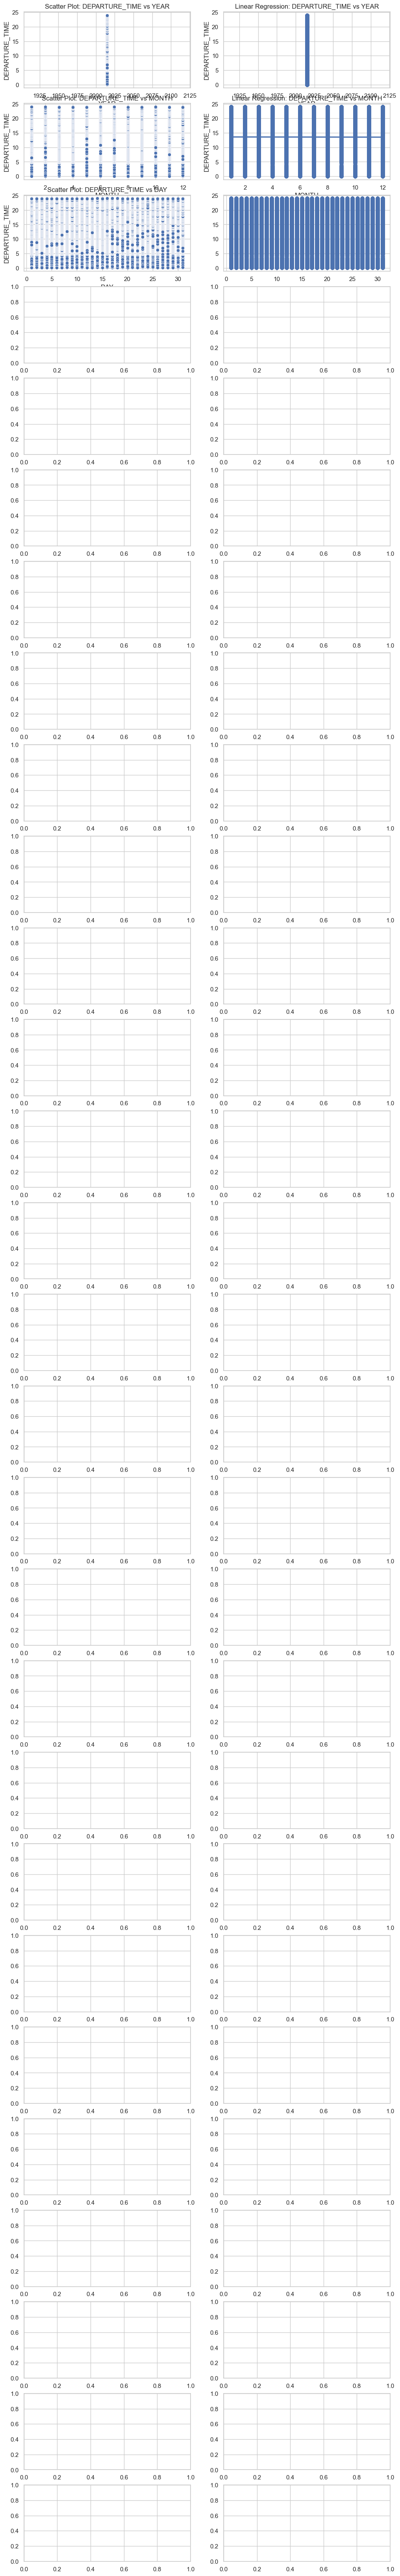

In [9]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Polars DataFrame to Pandas for plotting
df_pandas = df.to_pandas()

# List of numeric columns excluding DEPARTURE_TIME itself
numeric_columns = df_pandas.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove("DEPARTURE_TIME")  # Remove the column we're analyzing

# Set up plot style
sns.set(style="whitegrid")

# Create scatter and regression plots for each variable vs DEPARTURE_TIME
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(12, len(numeric_columns) * 3))

for i, col in enumerate(numeric_columns):
    # Scatter Plot
    sns.scatterplot(x=df_pandas[col], y=df_pandas["DEPARTURE_TIME"], ax=axes[i, 0])
    axes[i, 0].set_title(f"Scatter Plot: DEPARTURE_TIME vs {col}")

    # Linear Regression Plot
    sns.regplot(x=df_pandas[col], y=df_pandas["DEPARTURE_TIME"], ax=axes[i, 1])
    axes[i, 1].set_title(f"Linear Regression: DEPARTURE_TIME vs {col}")

plt.tight_layout()
plt.show()


In [10]:
# Correlation Plot

In [14]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_correlation_heatmap(file_path):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Select only numeric columns for correlation
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]]
    correlation_df = df.select(numeric_cols).to_pandas().corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_df), k=1)

    # Set up the matplotlib figure
    plt.figure(figsize=(20, 16))
    
    # Create the heatmap with improved formatting
    sns.heatmap(correlation_df, 
                mask=mask,
                annot=True,
                cmap='RdBu_r',  # Red-Blue diverging colormap
                fmt='.2f',
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .5},
                annot_kws={'size': 8},
                vmin=-1, 
                vmax=1)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.title("Flight Data Correlation Matrix", pad=20, size=16)
    plt.tight_layout()
    
    # Save the plot with high DPI for better quality
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("Correlation heatmap has been saved as 'correlation_matrix.png'")

# Usage
file_path = "flights_cleaned.csv"
create_correlation_heatmap(file_path)

Correlation heatmap has been saved as 'correlation_matrix.png'


In [15]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_correlation_heatmap(file_path):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Select only numeric columns for correlation
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]]
    correlation_df = df.select(numeric_cols).to_pandas().corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_df), k=1)

    # Set up the matplotlib figure with a very large size
    plt.figure(figsize=(30, 24))
    
    # Create the heatmap with improved formatting
    sns.heatmap(correlation_df, 
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 12},
                vmin=-1, 
                vmax=1)

    # Improve label visibility
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    # Add title and adjust layout
    plt.title("Flight Data Correlation Matrix", pad=20, size=24, fontweight='bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot with high DPI for better quality
    # Set bbox_inches='tight' to ensure no labels are cut off
    plt.savefig('correlation_matrix_large.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    plt.close()

    print("Large correlation heatmap has been saved as 'correlation_matrix_large.png'")

# Create a function to display subset correlations if needed
def create_subset_correlation_heatmap(file_path, variables_of_interest):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Calculate correlation for subset of variables
    correlation_df = df.select(variables_of_interest).to_pandas().corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))
    
    # Create the heatmap
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 14},
                vmin=-1, 
                vmax=1)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title("Subset Correlation Matrix", pad=20, size=20, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('correlation_matrix_subset.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    plt.close()

# Usage
file_path = "flights_cleaned.csv"

# Create full correlation matrix
create_correlation_heatmap(file_path)

# Example of creating a subset correlation matrix for key delay-related variables
delay_variables = [
    "DEPARTURE_DELAY",
    "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]
create_subset_correlation_heatmap(file_path, delay_variables)



Large correlation heatmap has been saved as 'correlation_matrix_large.png'


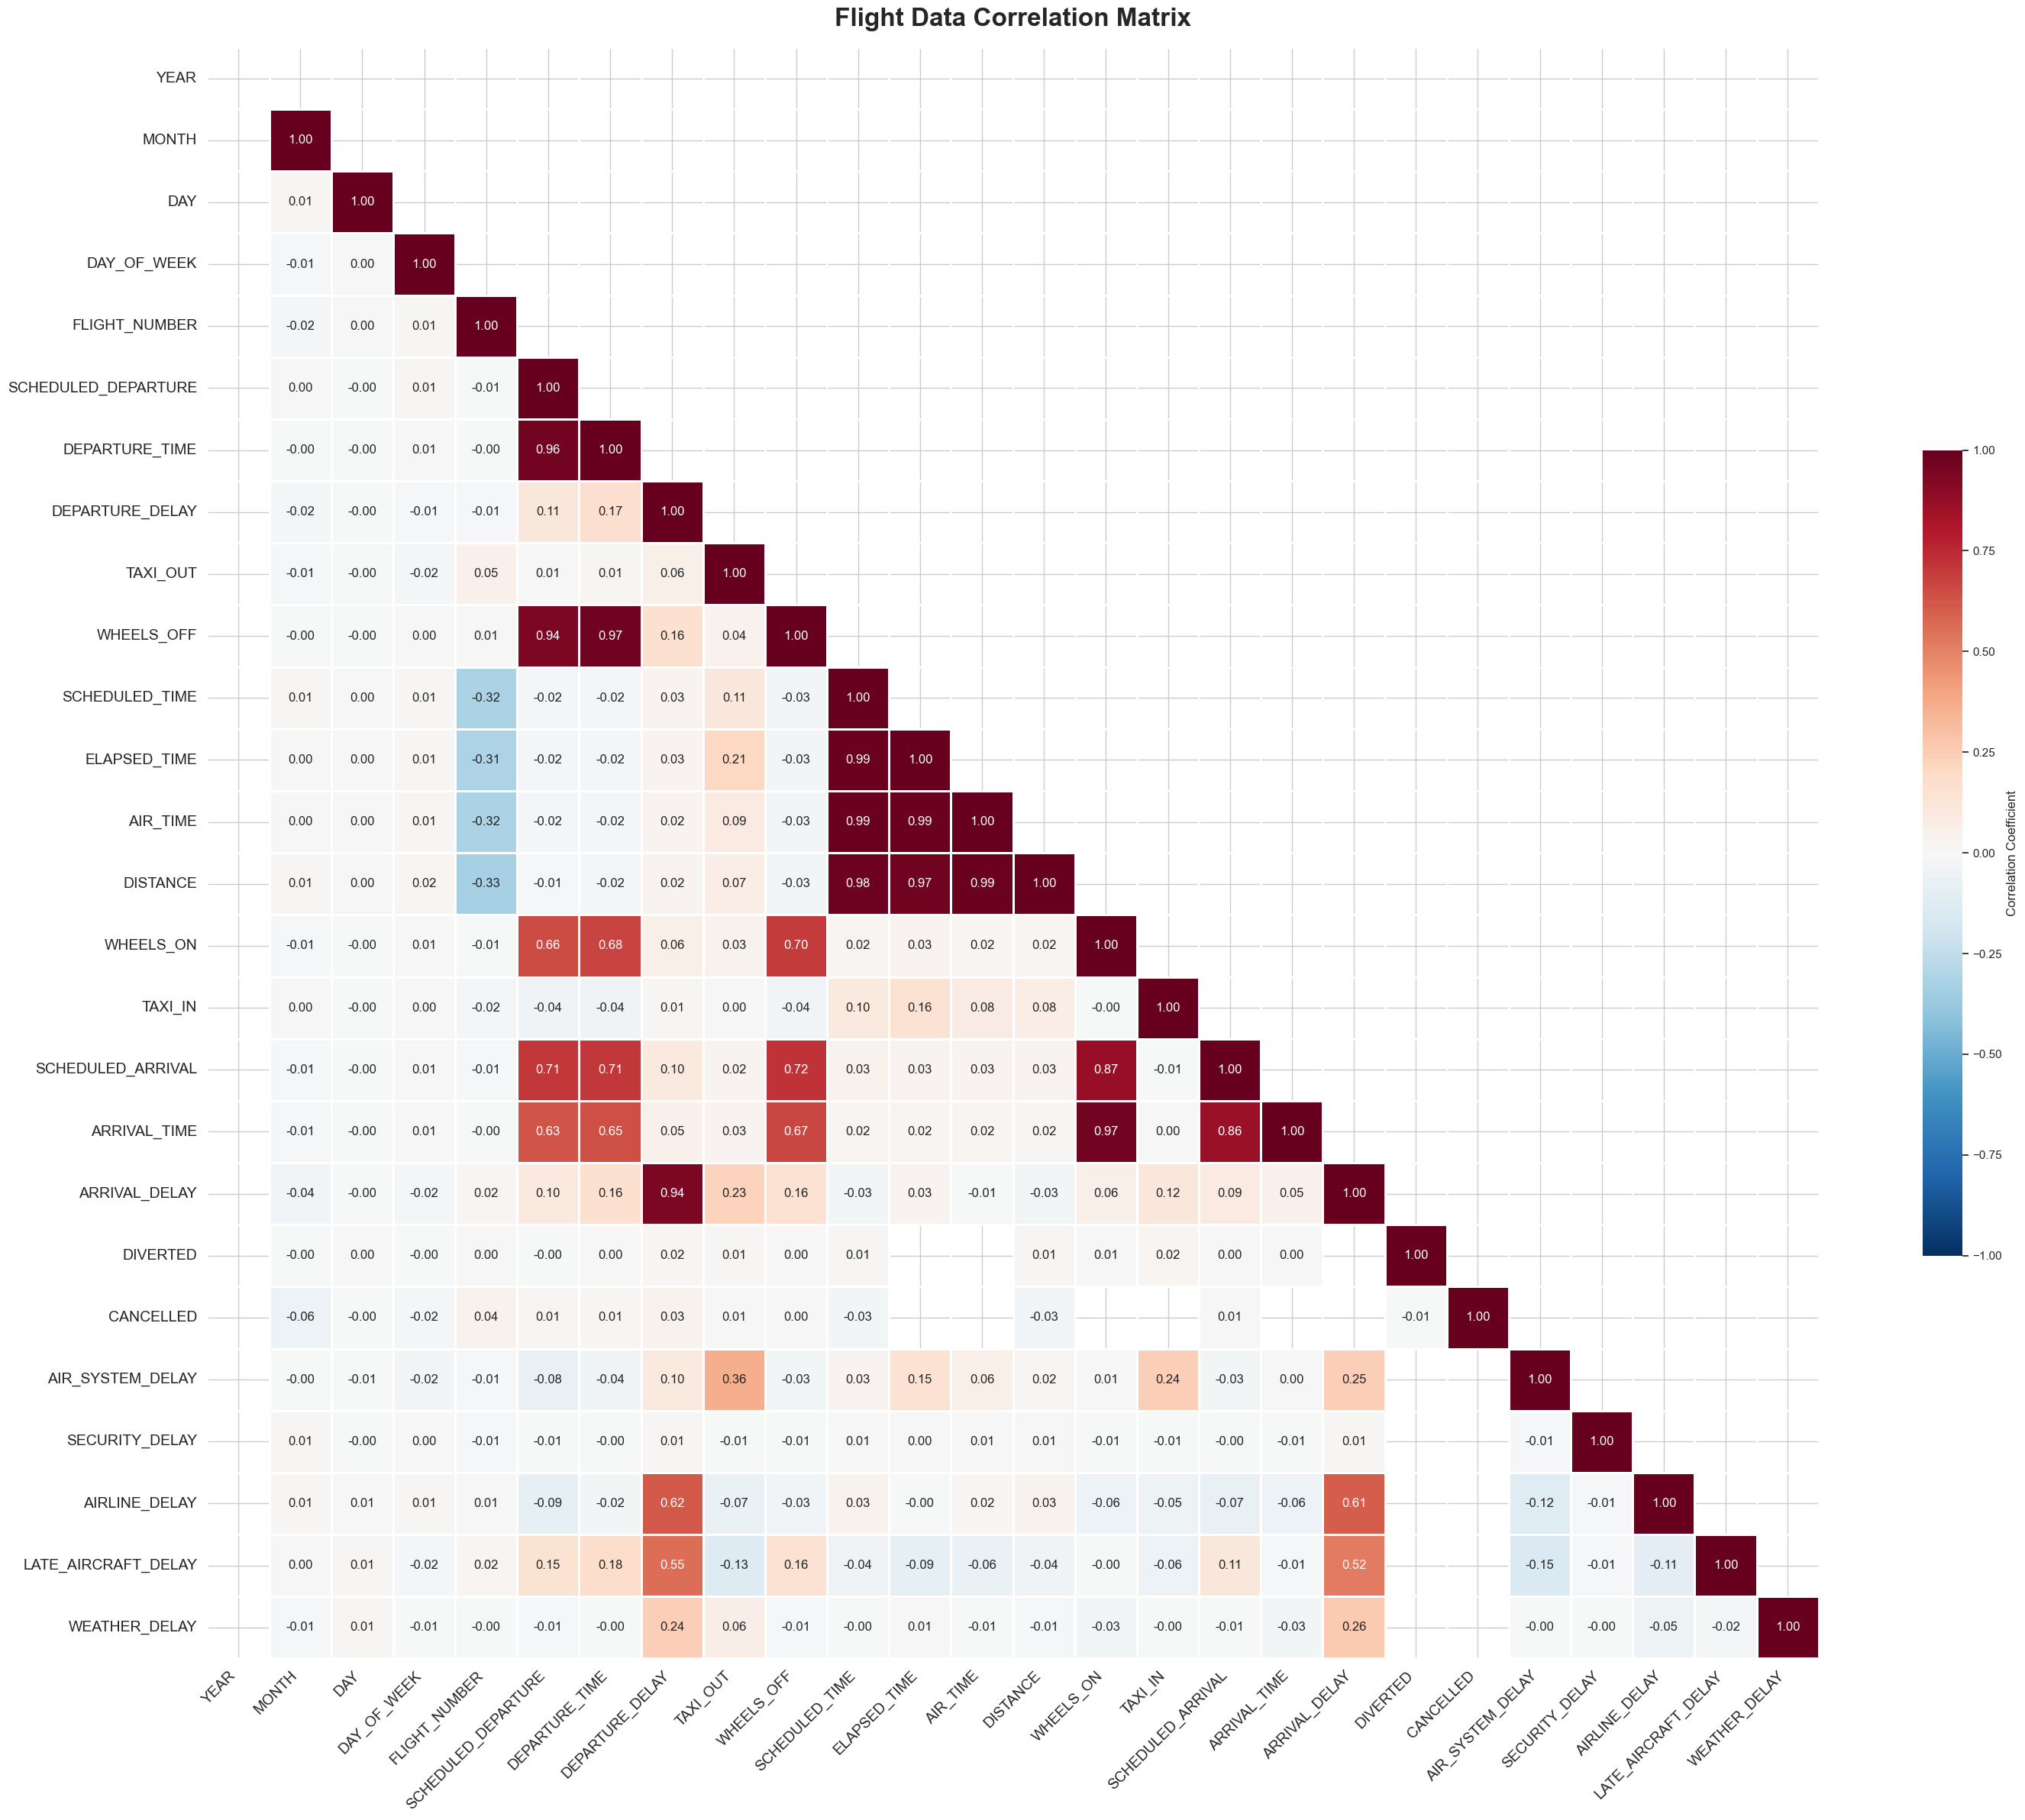

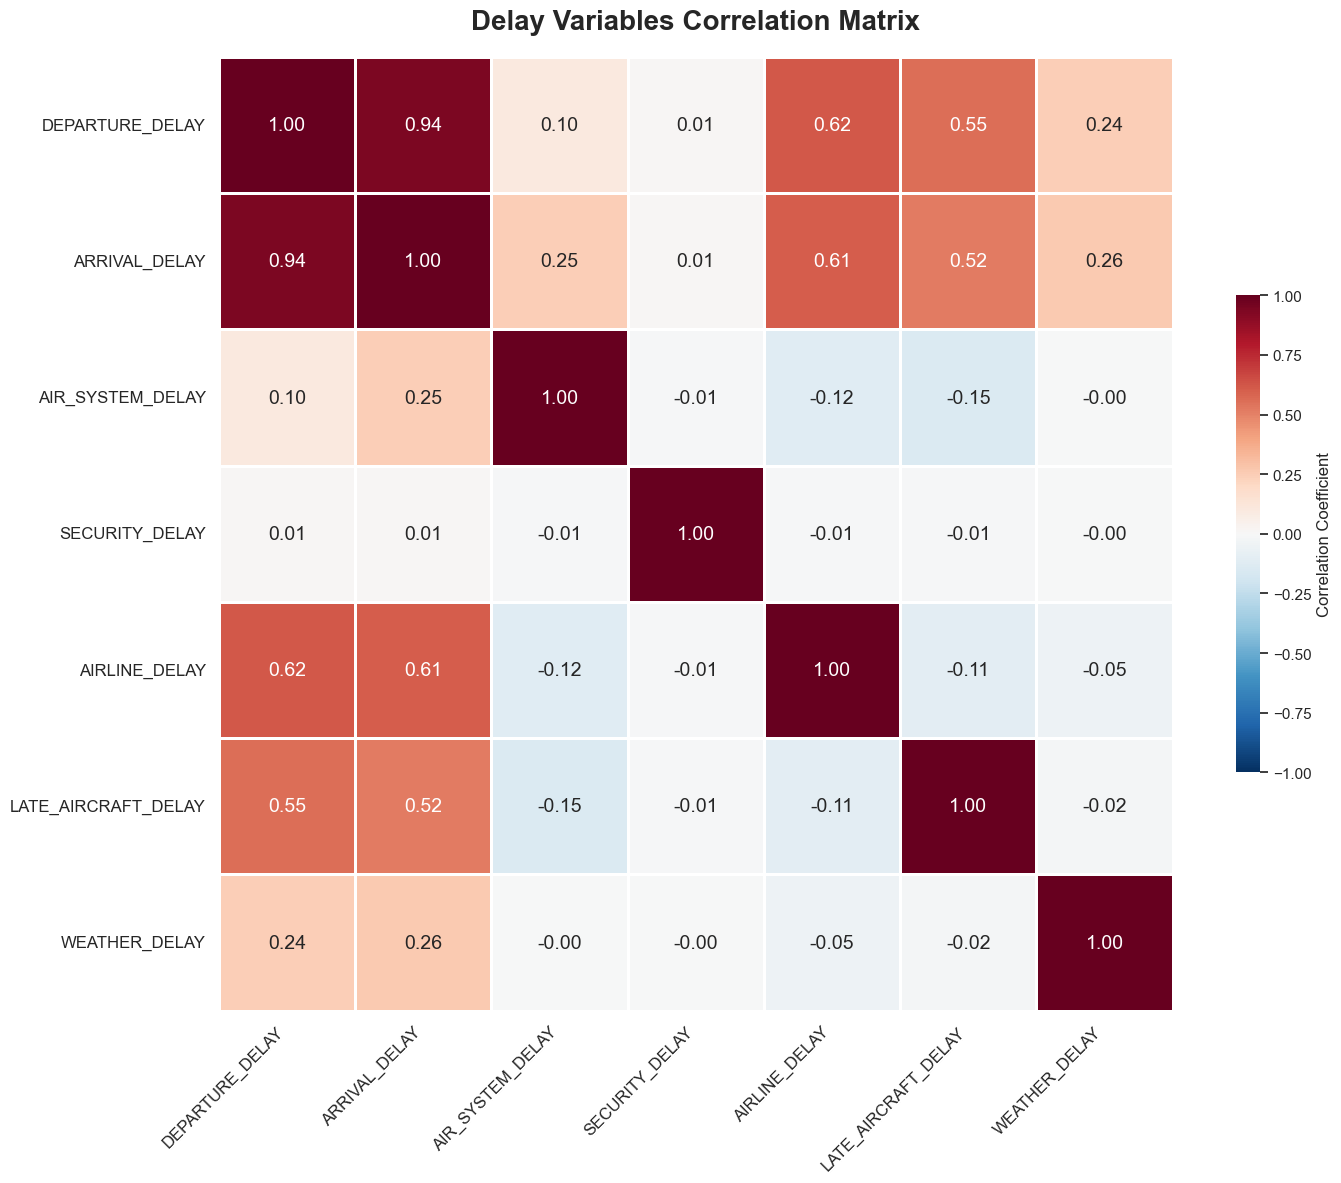

In [16]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def display_correlation_heatmap(file_path):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Select only numeric columns for correlation
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]]
    correlation_df = df.select(numeric_cols).to_pandas().corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_df), k=1)

    # Set up the matplotlib figure with a very large size
    plt.figure(figsize=(30, 24))
    
    # Create the heatmap with improved formatting
    sns.heatmap(correlation_df, 
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 12},
                vmin=-1, 
                vmax=1)

    # Improve label visibility
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    # Add title and adjust layout
    plt.title("Flight Data Correlation Matrix", pad=20, size=24, fontweight='bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def display_subset_correlation_heatmap(file_path, variables_of_interest):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Calculate correlation for subset of variables
    correlation_df = df.select(variables_of_interest).to_pandas().corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))
    
    # Create the heatmap
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 14},
                vmin=-1, 
                vmax=1)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title("Delay Variables Correlation Matrix", pad=20, size=20, fontweight='bold')
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Usage
file_path = "flights.csv"

# Display full correlation matrix
display_correlation_heatmap(file_path)

# Display subset correlation matrix for key delay-related variables
delay_variables = [
    "DEPARTURE_DELAY",
    "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]
display_subset_correlation_heatmap(file_path, delay_variables)



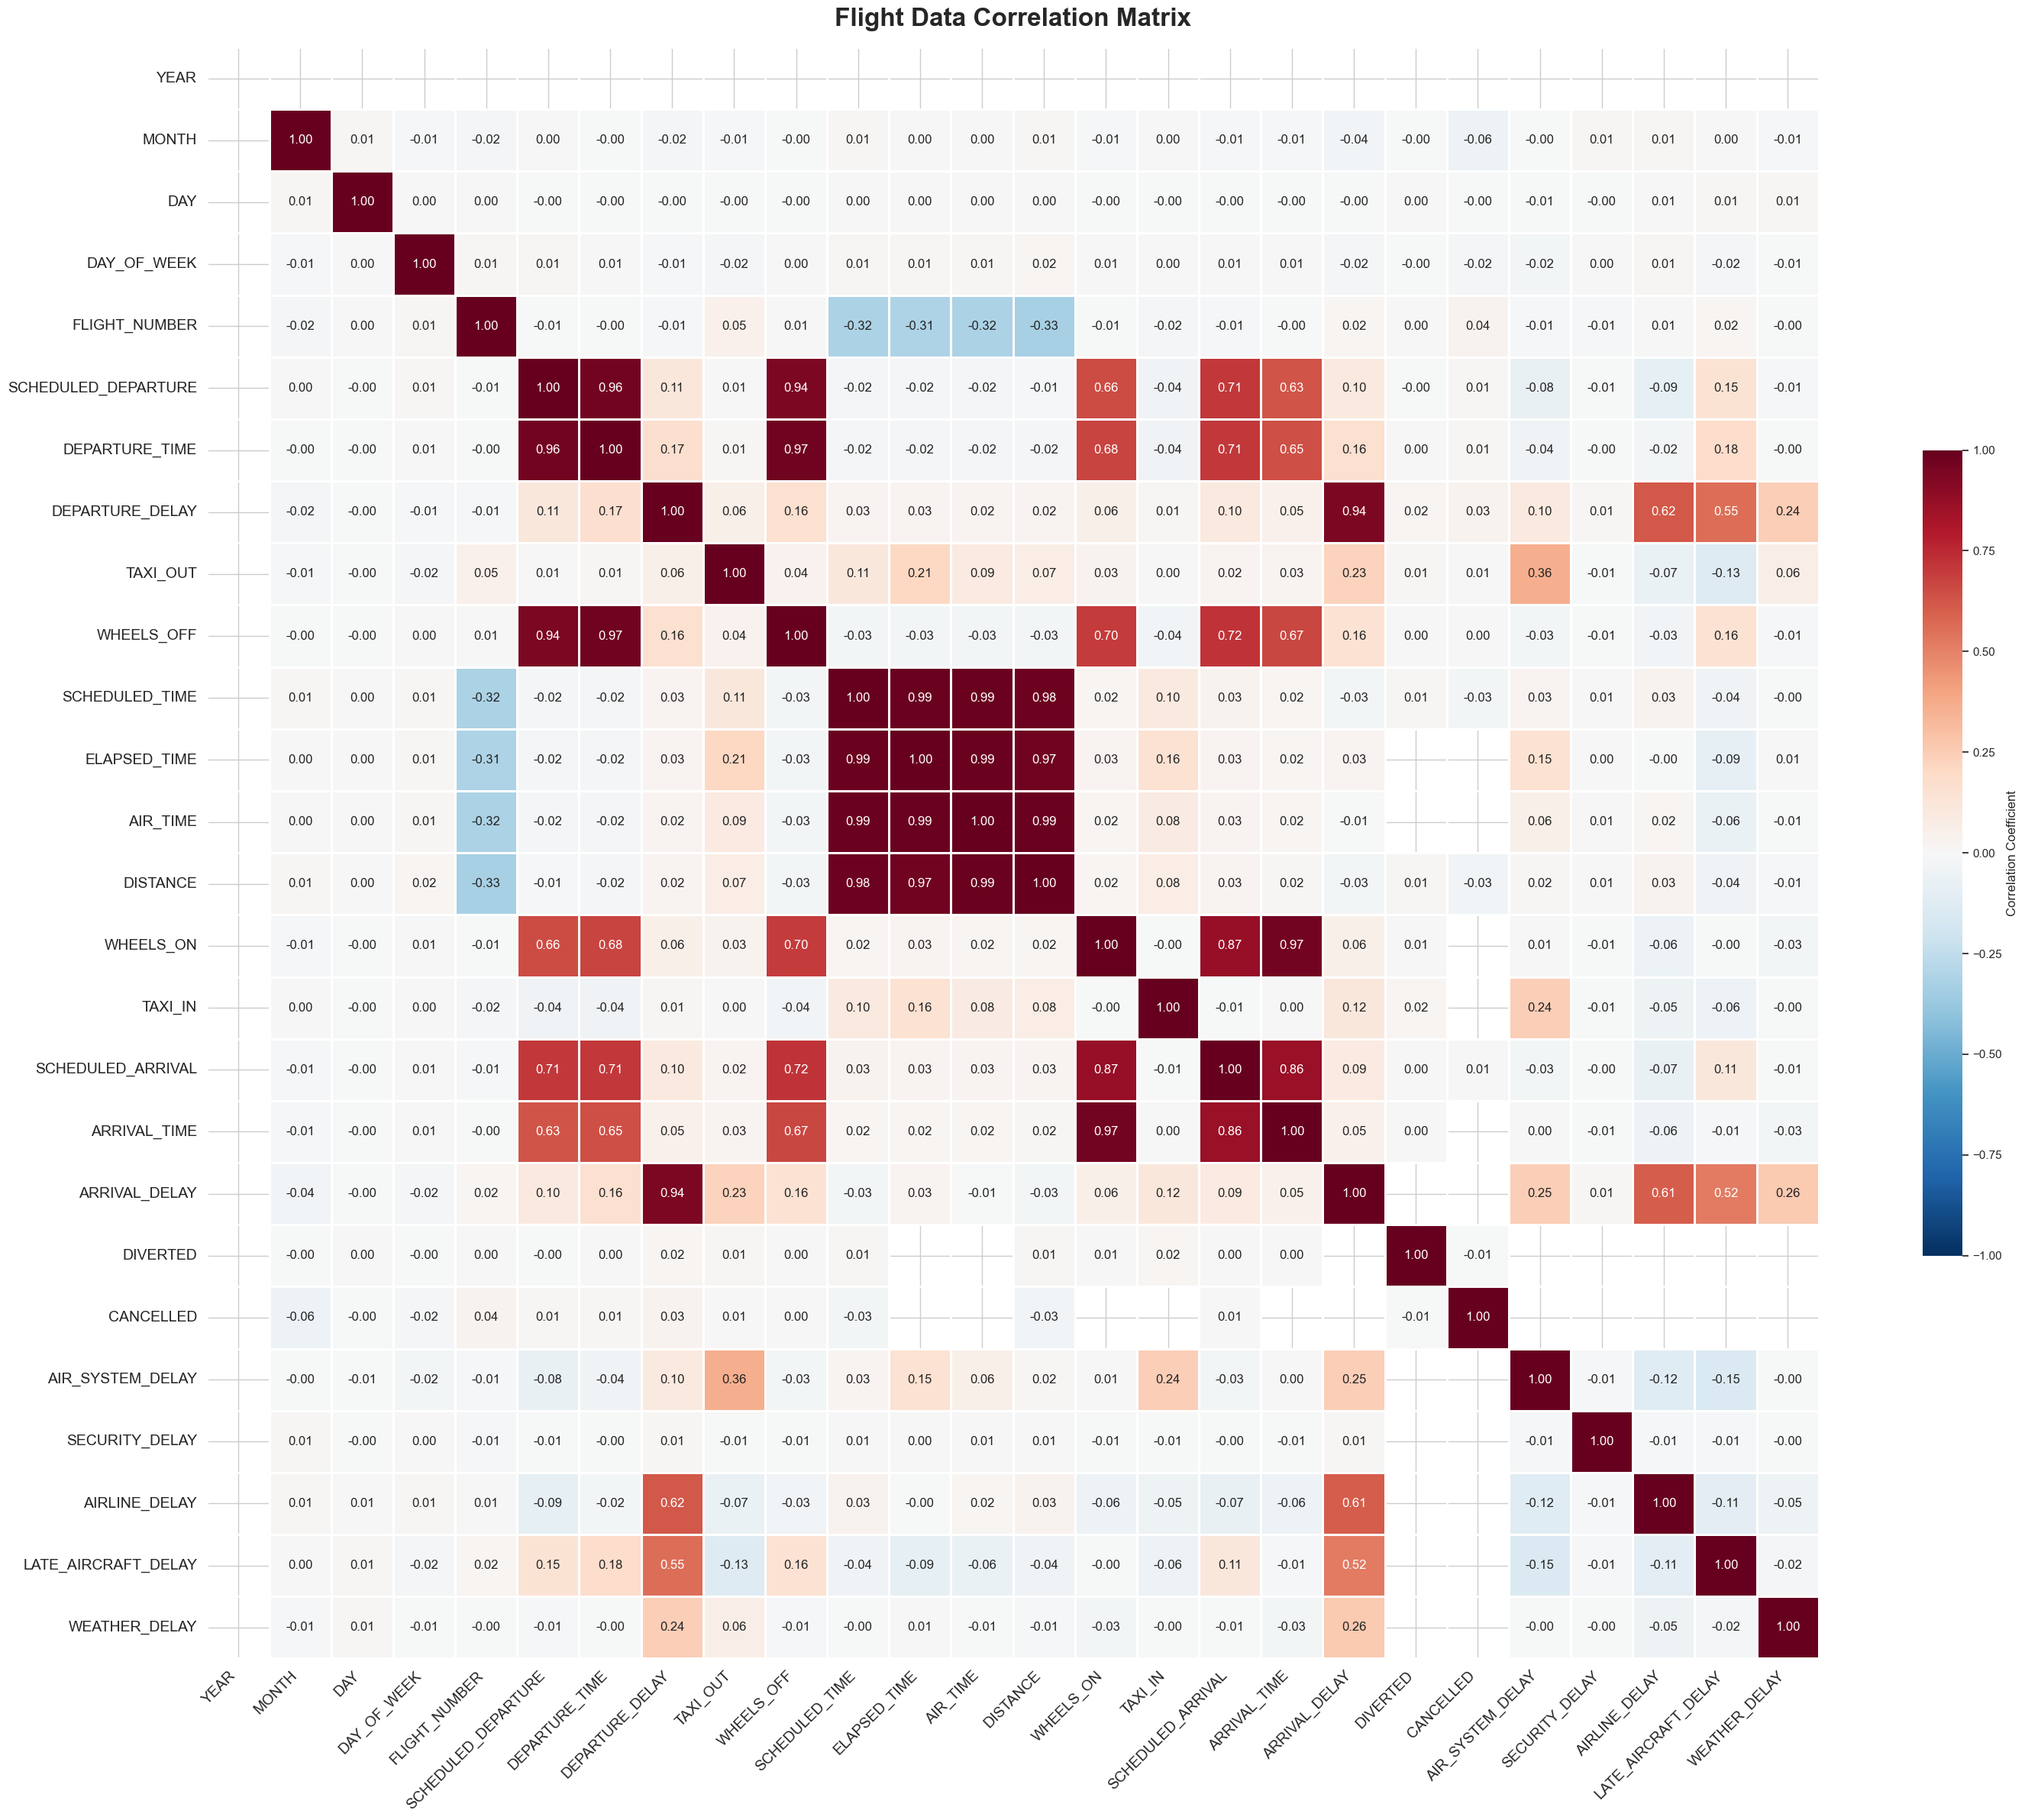

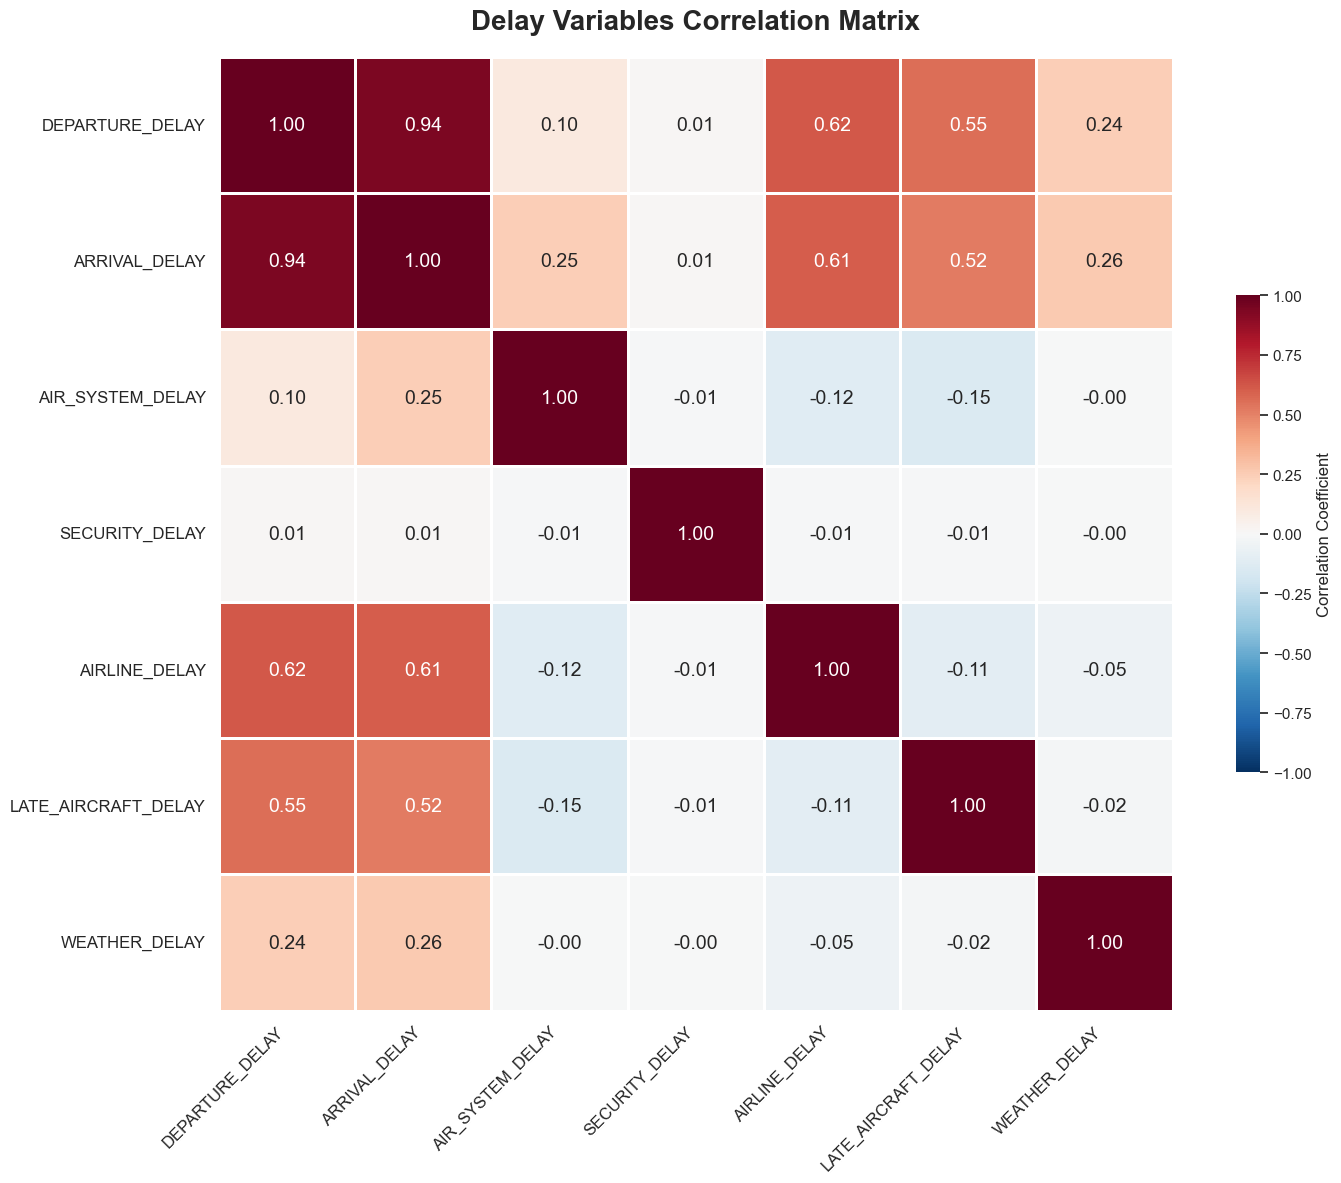

In [17]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def display_correlation_heatmap(file_path):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Select only numeric columns for correlation
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]]
    correlation_df = df.select(numeric_cols).to_pandas().corr()

    # Set up the matplotlib figure with a very large size
    plt.figure(figsize=(30, 24))
    
    # Create the heatmap with improved formatting - removed the mask parameter
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 12},
                vmin=-1, 
                vmax=1)

    # Improve label visibility
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    # Add title and adjust layout
    plt.title("Flight Data Correlation Matrix", pad=20, size=24, fontweight='bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def display_subset_correlation_heatmap(file_path, variables_of_interest):
    # Read the data using polars
    df = pl.read_csv(file_path)
    
    # Calculate correlation for subset of variables
    correlation_df = df.select(variables_of_interest).to_pandas().corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))
    
    # Create the heatmap - removed the mask parameter here as well
    sns.heatmap(correlation_df, 
                annot=True,
                cmap='RdBu_r',
                fmt='.2f',
                square=True,
                linewidths=1,
                cbar_kws={"shrink": .5, "label": "Correlation Coefficient"},
                annot_kws={'size': 14},
                vmin=-1, 
                vmax=1)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title("Delay Variables Correlation Matrix", pad=20, size=20, fontweight='bold')
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Usage
file_path = "flights.csv"

# Display full correlation matrix
display_correlation_heatmap(file_path)

# Display subset correlation matrix for key delay-related variables
delay_variables = [
    "DEPARTURE_DELAY",
    "ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]
display_subset_correlation_heatmap(file_path, delay_variables)

